In [2]:
%%bash -e
if ! [[ -f ./linkern ]]; then
  wget http://www.math.uwaterloo.ca/tsp/concorde/downloads/codes/src/co031219.tgz
  echo 'c3650a59c8d57e0a00e81c1288b994a99c5aa03e5d96a314834c2d8f9505c724  co031219.tgz' | sha256sum -c
  tar xf co031219.tgz
  (cd concorde && CFLAGS='-O3 -march=native -mtune=native -fPIC' ./configure --build=x86_64)
  (cd concorde/LINKERN && make -j && cp linkern ../../)
  rm -rf concorde co031219.tgz
fi

In [4]:
from concorde.tsp import TSPSolver
from matplotlib import collections  as mc
import numpy as np
import pandas as pd
import time
import pylab as pl

In [6]:
cities = pd.read_csv('cities.csv', index_col=['CityId'])

In [7]:
cities1k = cities * 1000

In [8]:
def write_tsp(cities, filename, name='traveling-santa-2018-prime-paths'):
    with open(filename, 'w') as f:
        f.write('NAME : %s\n' % name)
        f.write('COMMENT : %s\n' % name)
        f.write('TYPE : TSP\n')
        f.write('DIMENSION : %d\n' % len(cities))
        f.write('EDGE_WEIGHT_TYPE : EUC_2D\n')
        f.write('NODE_COORD_SECTION\n')
        for row in cities.itertuples():
            f.write('%d %.11f %.11f\n' % (row.Index+1, row.X, row.Y))
        f.write('EOF\n')

write_tsp(cities1k, 'cities1k.tsp')

In [ ]:
%%bash -e
time ./linkern -s 42 -S linkern.tour -R 1000000000 -t 18000 ./cities1k.tsp >linkern.log

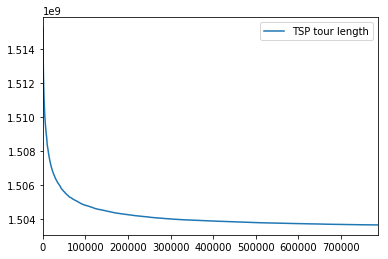

In [10]:
!sed -Ene 's/([0-9]+) Steps.*Best: ([0-9]+).*/\1,\2/p' linkern.log >linkern.csv
pd.read_csv('linkern.csv', index_col=0, names=['TSP tour length']).plot();

In [21]:
import sympy
def read_tour(filename):
    tour = open(filename).read().split()[1:]
    tour = list(map(int, tour))
    if tour[-1] == 0: tour.pop()
    return tour

def score_tour(tour):
    df = cities.reindex(tour + [0]).reset_index()
    primes = list(sympy.primerange(0, len(cities)))
    df['prime'] = df.CityId.isin(primes).astype(int)
    df['dist'] = np.hypot(df.X - df.X.shift(-1), df.Y - df.Y.shift(-1))
    df['penalty'] = df['dist'][9::10] * (1 - df['prime'][9::10]) * 0.1
    return df.dist.sum() + df.penalty.sum()

def write_submission(tour, filename):
    assert set(tour) == set(range(len(tour)))
    pd.DataFrame({'Path': list(tour) + [0]}).to_csv(filename, index=False)

In [22]:
tour = read_tour('linkern.tour')
write_submission(tour, 'submission.csv')

In [25]:
score_tour(tour)

1517361.2529791819

In [39]:
def flip(lst, k):
    return lst[0:1] + lst[k+1:] + lst[1:k+1]

In [43]:
print("Tour path (0-5):",tour[0:5])
tourflip = tour[::-1]
print("Flipped tour path (0-5):", tourflip[0:5])

('Tour path (0-5):', [78934, 111804, 52086, 89712, 81072])
('Flipped tour path (0-5):', [0, 48816, 40230, 75405, 153911])


In [40]:
originScore = score_tour(tour)
print("Score of original tour:", originScore)
tourflip = tour
for n in range(1,101):
    # And the flipped tour looks like:
    tourflip = flip(tourflip, 1)
    # The scores of our tours are:
    flippedScore = score_tour(tourflip)
    print("Score of flipped tour:", flippedScore)

    # If the flipped tour is quicker, change our tour:
    if flippedScore < originScore:
        print("The total improvement was:", abs(flippedScore - originScore))
        originScore = flippedScore
        tour = tourflip 
        print("The better of the original/flipped tour is:", tour[0:5])

('Score of original tour:', 1517332.415616737)
('Score of flipped tour:', 1517356.0910889404)
('Score of flipped tour:', 1517356.9139951372)
('Score of flipped tour:', 1517413.2228083517)
('Score of flipped tour:', 1517403.1202388373)
('Score of flipped tour:', 1517403.8425916804)
('Score of flipped tour:', 1517390.3233206801)
('Score of flipped tour:', 1517426.1401942007)
('Score of flipped tour:', 1517471.5298787779)
('Score of flipped tour:', 1517440.7268941959)
('Score of flipped tour:', 1517424.4124984485)
('Score of flipped tour:', 1517426.253180478)
('Score of flipped tour:', 1517421.8727339443)
('Score of flipped tour:', 1517460.3421580733)
('Score of flipped tour:', 1517434.6743891994)
('Score of flipped tour:', 1517418.130972293)
('Score of flipped tour:', 1517393.934870807)
('Score of flipped tour:', 1517420.2643460205)
('Score of flipped tour:', 1517447.2864386647)
('Score of flipped tour:', 1517407.5226760462)
('Score of flipped tour:', 1517394.2942589528)
('Score of flipp

In [41]:
score_tour(tour)

1517332.415616737

In [32]:
write_submission(tour, 'submission.csv')